In [293]:
from tiffConverter import convert_to_numpy
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [294]:
recon_location = "/Users/levih/Desktop/TomoMono/reconstructions/foamRecon_notNormalized_20240717-143914_gpu.tif"
# recon_location = "/Users/levih/Desktop/TomoMono/reconstructions/foamRecon20240709-152238.tif"
tomo, tomo_scale_info = convert_to_numpy(recon_location)

520 900 900


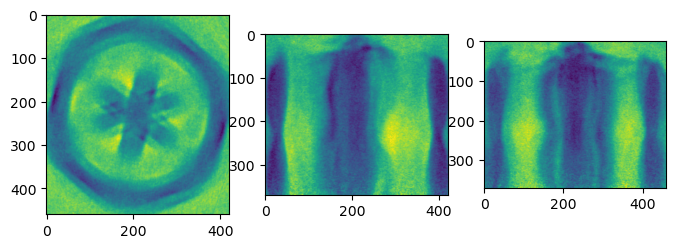

In [295]:
#Volume dimensions
w,h,d = np.shape(tomo)
print(w,h,d)

fig1, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8,8))

#Dimensions for cropped image (used later for electron density)
a, b = 150, 520
c, d = 220, 680
e, f = 240, 660
axs[0].imshow(tomo[260,c:d,e:f])
axs[1].imshow(tomo[a:b,450,e:f])
axs[2].imshow(tomo[a:b,c:d,450])

## Calculate scale info from one projection

In [296]:
ang = tomopy.angles(5, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
# tomopyProj = tomopy.project(tomo, ang)[0] ## uncomment to first figure out the values for kevinProj_p5 and p95

In [297]:
## Uncomment to scale tomo data first based on kevinProj
tomo_p5, tomo_p95 = np.percentile(tomo, [5, 95])
kevinProj_p5 = -0.1061777975410223 #Based on running the code for just one projection
kevinProj_p95 = 0.06364169009029864 #Based on running the code for just one projection

# Normalize tomo to [0, 1] based on its 5th and 95th percentiles (since upper outliers are skewing data)
tomo_normalized = (tomo - tomo_p5) / (tomo_p95 - tomo_p5)
# Scale to [kevinProj_p5, kevinProj_p95]
tomo_scaled = tomo_normalized * (kevinProj_p95 - kevinProj_p5) + kevinProj_p5

tomopyProj = tomopy.project(tomo_scaled, ang)[0]

In [298]:
#Read in Kevin projection for reference
aligned_proj_location = "/Users/levih/Desktop/TomoMono/alignedProjections/aligned_foamTomo20240716-100346.tif"
kevinProj, kevin_proj_scale_info = convert_to_numpy(aligned_proj_location)
kevinProj = kevinProj[0]

#Crop to correct region like tomopy
w, h = kevinProj.shape
res = cv2.matchTemplate(tomopyProj.astype(np.float32),kevinProj.astype(np.float32),cv2.TM_CCOEFF_NORMED)
loc = np.where( res == res.max())
print(loc)
pt = list(zip(*loc[::-1]))[0]
print(pt)
tomopyProj_cropped = tomopyProj[pt[1]:w + pt[1] , pt[0]: h+pt[0] ]

# Crop out zero padded region (since it is messing with the histogram)
tomopyProj_cropped = tomopyProj_cropped[:,100:700]
kevinProj = kevinProj[:,100:700]

(array([0]), array([226]))
(226, 0)


In [299]:
# # Uncomment to match max and min
# # Calculate min and max of proj_scaled and image_proj
# tomopyProj_cropped_min, tomopyProj_cropped_max = tomopyProj_cropped.min(), tomopyProj_cropped.max()
# kevinProj_min, kevinProj_max = kevinProj.min(), kevinProj.max()
# # Scale proj_scaled to match the range of image_proj
# tomopyProj_cropped_normalized = (tomopyProj_cropped - tomopyProj_cropped_min) / (tomopyProj_cropped_max - tomopyProj_cropped_min)  # Normalize proj_scaled to [0, 1]
# tomopyProj_scaled = tomopyProj_cropped_normalized * (kevinProj_max - kevinProj_min) + kevinProj_min  # Scale to [image_proj_min, image_proj_max]

# Uncomment to match 5th and 95th percentile
# Calculate the 5th and 95th percentiles of tomopyProj_cropped and kevinProj
tomopyProj_cropped_p5, tomopyProj_cropped_p95 = np.percentile(tomopyProj_cropped, [5, 95])
kevinProj_p5, kevinProj_p95 = np.percentile(kevinProj, [5, 95])
print("kevinProj_p5: ", kevinProj_p5)
print("kevinProj_p95: ", kevinProj_p95)
# Normalize tomopyProj_cropped to [0, 1] based on its 5th and 95th percentiles
tomopyProj_cropped_normalized = (tomopyProj_cropped - tomopyProj_cropped_p5) / (tomopyProj_cropped_p95 - tomopyProj_cropped_p5)
# Scale to [kevinProj_p5, kevinProj_p95]
tomopyProj_scaled = tomopyProj_cropped_normalized * (kevinProj_p95 - kevinProj_p5) + kevinProj_p5

kevinProj_p5:  -0.1061777975410223
kevinProj_p95:  0.06364169009029864


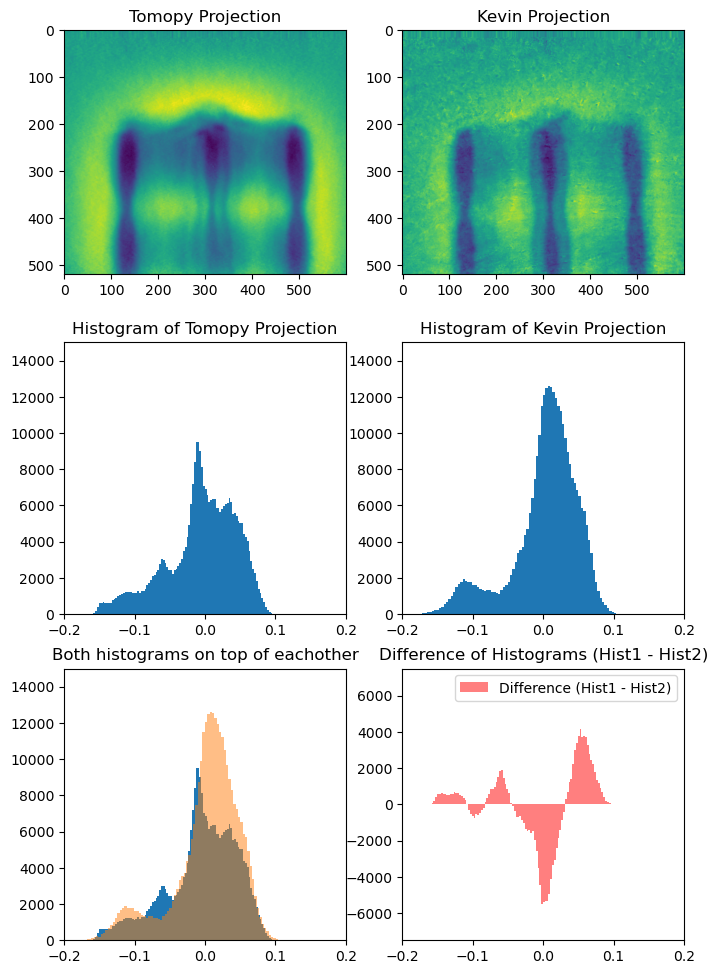

In [300]:
#Plotting
fig1, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
axs[0,0].imshow(tomopyProj_scaled)
axs[0,0].set_title('Tomopy Projection')
axs[1,0].hist(np.ndarray.flatten(tomopyProj_scaled),100)
axs[1,0].set_title('Histogram of Tomopy Projection')
axs[1,0].set_ylim(0,15000)
axs[1,0].set_xlim(-0.2,0.2)

axs[0,1].imshow(kevinProj)
axs[0,1].set_title('Kevin Projection')
axs[1,1].hist(np.ndarray.flatten(kevinProj),100)
axs[1,1].set_title('Histogram of Kevin Projection')
axs[1,1].set_ylim(0,15000)
axs[1,1].set_xlim(-0.2,0.2)

axs[2,0].hist(np.ndarray.flatten(tomopyProj_scaled),100)
axs[2,0].hist(np.ndarray.flatten(kevinProj),100, alpha=0.5)
axs[2,0].set_ylim(0,15000)
axs[2,0].set_xlim(-0.2,0.2)
axs[2,0].set_title('Both histograms on top of eachother')

# Create histograms
bins = 100  # You can adjust the number of bins
hist1, bin_edges1 = np.histogram(tomopyProj_scaled, bins=bins)
hist2, bin_edges2 = np.histogram(kevinProj, bins=bins)

# Subtract the histograms
hist_diff = hist1 - hist2

# Plot the histograms and their difference
bin_centers = (bin_edges1[:-1] + bin_edges1[1:]) / 2
axs[2,1].bar(bin_centers, hist_diff, width=bin_edges1[1] - bin_edges1[0], alpha=0.5, label='Difference (Hist1 - Hist2)', color='red')
axs[2,1].legend()
axs[2,1].set_title('Difference of Histograms (Hist1 - Hist2)')
axs[2,1].set_ylim(-7500,7500)
axs[2,1].set_xlim(-0.2,0.2)

plt.show()

## Electron and Mass density calculations

Text(0.5, 0, 'Raw phase shift per voxel')

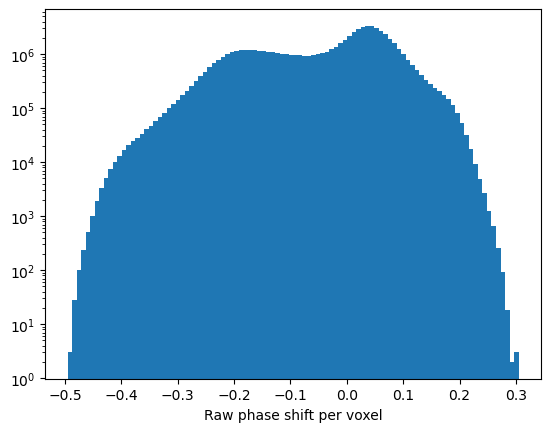

In [301]:
rough_volume = tomo_scaled[a:b, c:d, e:f]
plt.hist(np.ndarray.flatten(rough_volume), 100, log=True)
plt.xlabel('Raw phase shift per voxel')

In [302]:
#Shift so phase difference of peak is 0
from scipy.signal import find_peaks
count, division = np.histogram(np.ndarray.flatten(rough_volume), 100)

print(np.argmax(count, axis = None))
ind = np.argmax(count, axis = None)
print(division[-1])

rough_volume = rough_volume - division[-1]

66
0.3047558


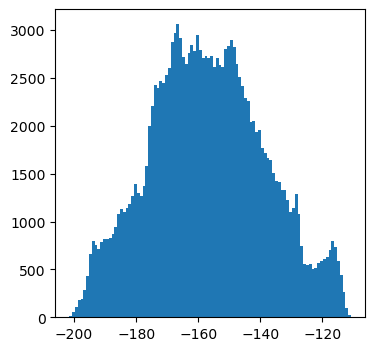

In [303]:
#Doublecheck projection through volume phase distribution
rough_volume_proj_check = np.sum(rough_volume, 1)

fig1, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
h = axs.hist(np.ndarray.flatten(rough_volume_proj_check),100)
plt.show()

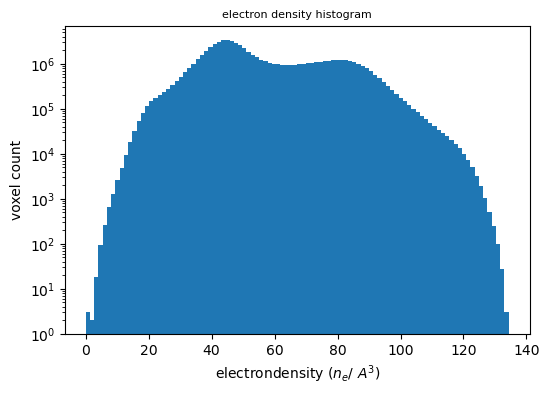

In [304]:
#Convert to electron density
import scipy.constants as constants
u = constants.physical_constants['atomic mass constant'][0]
wavelength = 1239.8 / 8800 * 10**(-9) #This needs to change
r_0 = constants.physical_constants['classical electron radius'][0]
A_bar = 62.546 #This needs to change
Z_bar = 29 #This needs to change

vol_proj_shift_edensity = - (rough_volume) / (wavelength * r_0) * (1/ (15*10**-9)) * (10**-10)**3

fig4, ax = plt.subplots(1, figsize=(6,4))
ax.hist(np.ndarray.flatten(vol_proj_shift_edensity), 100, log=True)
ax.set_title('electron density histogram', fontsize=8)
ax.set_xlabel('electrondensity ($n_e$/ $A^3$)')
ax.set_ylabel('voxel count')
# ax.set_xlim(0,3)
plt.show()

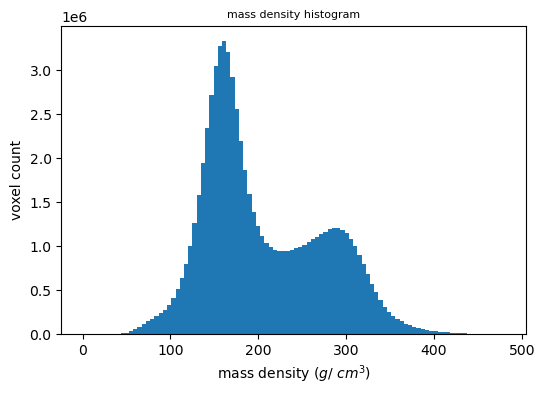

In [305]:
#Convert to mass density
vol_proj_shift_mdensity = vol_proj_shift_edensity * u * (A_bar/ Z_bar)

#convert kg/A^3 to g/cm^3
vol_proj_shift_mdensity = vol_proj_shift_mdensity * 1000 * (10**8)**3

fig5, ax = plt.subplots(1, figsize=(6,4))
ax.hist(np.ndarray.flatten(vol_proj_shift_mdensity), 100, log=False)
ax.set_title('mass density histogram', fontsize=8)
ax.set_xlabel('mass density ($g$/ $cm^3$)')
ax.set_ylabel('voxel count')
plt.show()